<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/%F0%9F%9B%A0_Time_Series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get myself familiar with working with the time series data. In here, we're going to build a series of models in an attempt to predict the price of a **Bitcoin**

> 🔑 Note: ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## Things we're going to cover 

- Get time series data (the historical price of Bitcoin)
  - Load in time series data using pandas/Python's CSV module
- Format data for a time series problem 
  - Creating training and test sets (the wrong way)
  - Creating training and test sets (the right way)
  - Visualizing time series data
  - Turning time series data into a supervised learning problem (windowing)
  - Preparing univariate and multivariate (more than one variable) data. 
- Evaluating a time series forecasting model. 
- Setting up a series of deeplearning modelling experiments. 
  - Dense (fully connected) networks 
  - Sequence models (LSTM and Conv1D) 
  - Ensembling (combining multiple models together) 
  - Multivariate models 
  - Replicating the N-BEATS algorithm (from the paper itself) using the TensorFlow Subclassing layers. 
- Creating a modelling checkpoint to save the best perfomring mdoel during training. 
- Making predictions (forecasts) with a time series model. 
- Creating prediction interval for time series model forecasts. 
- Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity). 
- Demonstrating why forecasting in an open system is BullShit (the turkey problem). 


### A bit about forecasting & Time Series 

Some things are easier to forecast than others. The time of the sunrise tomorrow morning can be forecast precisely. On the other hand, tomorrow’s lotto numbers cannot be forecast with any accuracy. The predictability of an event or a quantity depends on several factors including:

- how well we understand the factors that contribute to it;
- how much data is available;
- how similar the future is to the past;
- whether the forecasts can affect the thing we are trying to forecast.


### In a nutshell 

- Downloading and formatting time series data (the historical price of Bitcoin). 
- Writing **a preprocessing function** to preparrre our time series data 
- Setting up **multiple time series modelling experiments**. 
- Building a **multivariate model** to take in multivariate time series data. 
- Replicating the N-Beats algorithm using TensorFlow. 
- Making forecasts with **prediction intervals**. 
- Demonstrating **why time series forecasting can be bullshit** with the turkey problem. 


## Downloading the getting to know the data 
We're going to be using historical price of data of Bitcoin to try and predict the future price of Bitcoin. 

In [1]:
# Downloading the dat 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-08-24 14:33:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2021-08-24 14:33:24 (7.10 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



#### Importing the time series data using Pandas 

Let's use pandas and visualize the data in a pretty table. 

And because our data has a data component, we'll tell pandas to parse the dates using the `parse_dates` parameter pasing it the name of the data column. 

In [2]:
import pandas as pd 

# parse dates and set data column to index 
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv' , 
                 parse_dates = ['Date'] , 
                 index_col = ['Date']) # setting the Date col to index column 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
# Info about our data 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples do we have? 
len(df)

2787

We've collected the historical price of the Bitcoin for the past 8 years but there's only **2787 samples**. 

Typically deeplearning models usually like lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions). 

A smaller number of samples is something you'll often run into with time series data problems. 

> **Note**: The seasonality of the time series dataset is referred as the number of samples per yes. So for our Bitcoint data, it has a seasonlity of daily or value of 365 because we collect one sample per dat meaning we'll get 365 samples per year. 

There are various patterns in the time series data.  

- **Trend** —> time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal** —> time series affected by a seasonal factors such as time of year (e.g. increased sales towards end of year) or day of week.
- **Cyclic** —> time series shows rise and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

**Difference between season and cyclic** 

Seasonal is fixed where the things happen at a particular year or week etc.. But with cyclic its not the case, as there is no any time frame to determine when the events could take place

- **Univariate** --> Only one variable (using the price of Bitcoin to predict the price of Bitcoin). 
- **Multivariate** --> For Multivariate, there are more than one variable (using the price of Bitcoin as well as the block reward size  to predict the price of Bitcoin) which is using multiple features for prediction. 

In [5]:
# Only getting the closing price for each dat 
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns = {'Closing Price (USD)': 'Price'})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


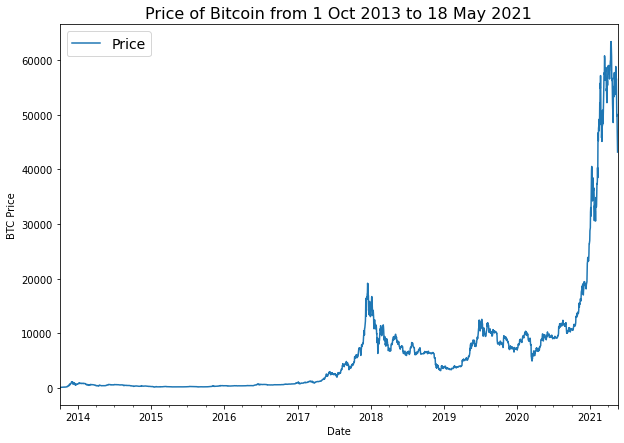

In [6]:
# Lets plot the prices vs data 
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (10 , 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021' , fontsize =16)
plt.legend(fontsize = 14);

#### Importing time series data with Python CSV module 

Its not always necessary to use pandas. We can use Python's built in csv module, and we also gotta use Python's `datetime`. 

Resources --> https://realpython.com/python-csv/

In [9]:
# Importing annd formatting historical Bitcoin data with Python 
import csv 
from datetime import datetime 

timesteps = []
btc_price = [] 
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv' , 'r') as f:
  csv_reader = csv.reader(f , delimiter = ',') # read the csv file using python csv lib 
  next(csv_reader) # iterate the rows and skip the first line (which is our header)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1] , '%Y-%m-%d')) # indexing into the dates and storing it in a list with datetime format
    btc_price.append(float(line[2])) # get the closing price as float 
                     

# View first 10 of each 
timesteps[:10] , btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0, 0.5, 'BTC Price')

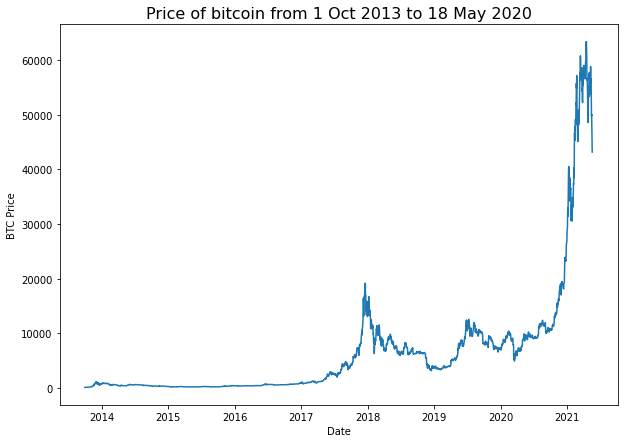

In [15]:
# Plot the aboce csv 
import matplotlib.pyplot as plt
import numpy as np 

plt.figure(figsize = (10 , 7))
plt.plot(timesteps , btc_price)
plt.title('Price of bitcoin from 1 Oct 2013 to 18 May 2020' , fontsize = 16)
plt.xlabel('Date')
plt.ylabel('BTC Price')

### Formatting Data Part 1 : Creating train and tests for our time series data 


Usually we will be creating a train and test split using a function like Scikit-learn's `train_test_split()` but its not the case for the time series data. 

Before splitting we should know what kind of data we're dealing with and we will either have a **univariate data** or **multivariate data**. 
- **Univariate** time series data deals with one variable, for example using the price of Bitcoint to predict the price of Bitcoin.
- **Multivariate** time series data deals with more than one variable, for example predicting electricity demand using the day of week, time of year and number of houses in a region. 

> We're dealing with a univariate time series problem, so we have to make a split on one variable. 



#### Create train and test set for time series (the wrong way) 




In [17]:
# Get bitcoin data array 
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10] , prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [18]:
# Wrong way to make train/test set for time series 
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(timesteps , #dates 
                                                       prices , #prices , 
                                                       test_size = 0.2 , 
                                                       random_state = 42)

# Checking the shapes 
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((2229,), (558,), (2229,), (558,))

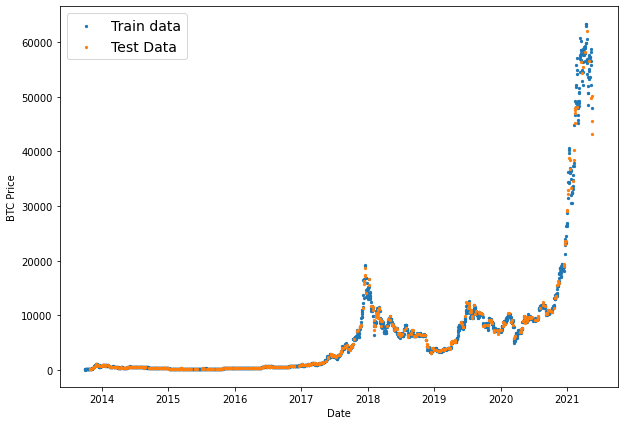

In [19]:
# Lets visualize the splits we made 
plt.figure(figsize = (10 , 7))
plt.scatter(X_train , y_train , s = 5 , label ='Train data')
plt.scatter(X_test , y_test , s = 5 , label = 'Test Data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize = 14)
plt.show()

The above split isn't the ideal way for a time series data because ur test data is scattered all throughout the training data. 

This kind of random splits will be fine for datasets without a time component, but for time series, we have to got take the time factor into account. 

In other words it is data leakage. 

We need to split our Historical Bitcoin data to have a **dataset that reflects the past (train set) and a dataset that reflects the future (test data or pseudo future)**.

#### Create train and test sets for a time series (the right way) 





In [20]:
split_size = int(0.8 * len(prices)) # 80% train , 20% test (can change this values)

# Create train data splits (everything before the split)
X_train , y_train = timesteps[:split_size] , prices[:split_size]

# Create test data splits (everything after the split)
X_test , y_test = timesteps[split_size:] , prices[split_size:]

len(X_train) , len(X_test) , len(y_train) , len(y_test)

(2229, 558, 2229, 558)

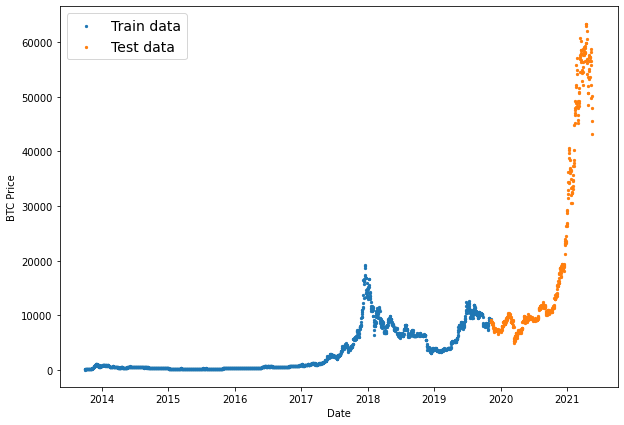

In [21]:
# Visualizing the above splits (the right one)
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Beautiful! Here we're going to be using the training set (past) to train a model to try and predict values on the test set (future). 

Our test set is an artifical future, at the end we can try our model on the whole data as a training set. 

> **🔑 Note** The amount of data you reserve for your test set is not set in stone. You could have 80/20 , 90/10 , 95/5 splits or in some cases, you might not even have a enough data to split into train and test sets. The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing. 

> 📖 Resource: Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [3 facts about time series forecasting that surprise experienced machine learning practitioners](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data, I'd recommend reading it.

##### Creating a plot function to visualize our time series data 



In [26]:
def plot_time_series(timesteps , values ,format = '.' , start = 0 , end = None , label = None):
  '''
  Plots a timesteps (a series of point in time) against values (a series of values across timesteps)

  Parameters 
  ----------

  timesteps : array of timesteps (date)
  values : array of values across time 
  format : style of plot , default '.'
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  '''

  # Plot the serie 
  plt.plot(timesteps[start:end] , values[start:end] , format , label = label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize = 14) # make label bigger
  plt.grid(True)

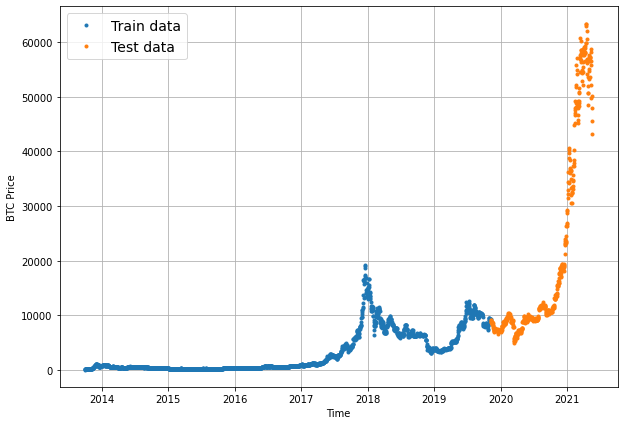

In [27]:
# Trying out our plotting function 
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = X_train , values = y_train , label ='Train data')
plot_time_series(timesteps = X_test , values = y_test , label = 'Test data')

## Modelling Experiments 

